# Action Grammars: A Grammar-Induction Based Method for Learning Temporally-Extended Actions
## Authors: Robert Lange and Aldo Faisal | January 2019

In [ ]:
!pip install -r requirements.txt --quiet

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import time
import numpy as np

import gym
import gym_hanoi

In [34]:
from agents import *
from utils.q_learning import q_learning
from utils.learning_params import *
from utils.general import *
from utils.plotting import *

In [35]:
# Create directory - Learning performance
results_dir = os.getcwd() + "/results/"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print("Created New Results Directory")

# Create directory - Log directory
log_dir = os.getcwd() + "/logs/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
    print("Created New Log Directory")
    
# Create directory - Figure directory
fig_dir = os.getcwd() + "/figures/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    print("Created New Fig Directory")

# Towers of Hanoi - Setup

In [70]:
num_episodes = 2000
max_steps = 500

log_freq = 100  # greedily evaluate policy after amount of episodes
log_episodes = 100
learning_times = 5

verbose = True

N = 4

alpha, gamma, lambd, epsilon = learning_parameters(l_type="Q-Learning")

### Simple TD($\lambda$) Learning

In [71]:
env = gym.make("Hanoi-v0")
env.set_env_parameters(num_disks=N, env_noise=0)

Q = QTable(env.get_movability_map())
agent = Agent_Q(env, Q)
er_buffer = ReplayBuffer(num_episodes*max_steps)

/Users/rtl/anaconda2/envs/AG/lib/python3.6/site-packages/gym-0.10.9-py3.6.egg/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Hanoi Environment Parameters have been set to:
	 Number of Disks: 4
	 Transition Failure Probability: 0


In [72]:
hist, er_buffer = q_learning(env, agent, num_episodes, max_steps,
                             gamma, alpha, lambd, log_freq, log_episodes, verbose)

Ep:  1 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 101 | Avg/Std Steps: 500.00/0.00 | Avg/Std Ret: 0.00/0.00 | Success R: 0.00
Ep: 201 | Avg/Std Steps: 22.00/0.00 | Avg/Std Ret: 34.06/0.00 | Success R: 1.00
Ep: 301 | Avg/Std Steps: 21.00/0.00 | Avg/Std Ret: 35.85/0.00 | Success R: 1.00
Ep: 401 | Avg/Std Steps: 21.00/0.00 | Avg/Std Ret: 35.85/0.00 | Success R: 1.00
Ep: 501 | Avg/Std Steps: 21.00/0.00 | Avg/Std Ret: 35.85/0.00 | Success R: 1.00
Ep: 601 | Avg/Std Steps: 20.00/0.00 | Avg/Std Ret: 37.74/0.00 | Success R: 1.00
Ep: 701 | Avg/Std Steps: 19.00/0.00 | Avg/Std Ret: 39.72/0.00 | Success R: 1.00
Ep: 801 | Avg/Std Steps: 19.00/0.00 | Avg/Std Ret: 39.72/0.00 | Success R: 1.00
Ep: 901 | Avg/Std Steps: 19.00/0.00 | Avg/Std Ret: 39.72/0.00 | Success R: 1.00
Ep: 1001 | Avg/Std Steps: 20.00/0.00 | Avg/Std Ret: 37.74/0.00 | Success R: 1.00
Ep: 1101 | Avg/Std Steps: 19.00/0.00 | Avg/Std Ret: 39.72/0.00 | Success R: 1.00
Ep: 1201 | Avg/Std Steps: 19.00/0.00 | 

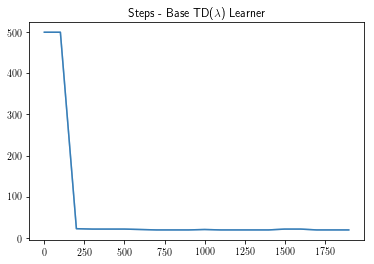

In [73]:
plot_learning(hist[:, 0], hist[:, 1], hist[:,2], title=r"Steps - Base TD($\lambda$) Learner")

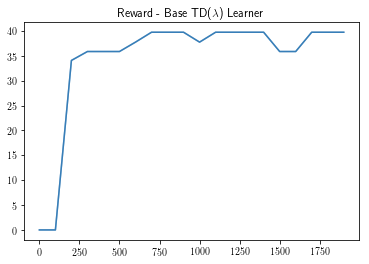

In [74]:
plot_learning(hist[:, 0], hist[:, 3], hist[:, 4], title=r"Reward - Base TD($\lambda$) Learner")

### SMDP-Q-Learning

In [ ]:
letter_to_move = {"a": 0, "b": 1, "c": 2,
                  "d": 3, "e": 4, "f": 5}

seq_macros = {4: ["abd"],
              5: ["bafbcd", "baf", "ec", "bc"],
              6: ["abdaef", "abdced", "abdaef", "aedce",
                  "abdce", "abd", "ae", "ce"], 
              7: ["bafbcdbafecfbafbcdbcfecd", "bafbcdbafecf",
                  "bafecdbcfecbafbcdbcfec", "bafbcdbafec",
                  "bcfecbafbcec"]}